### **Supervised Learning:** machine learning task of learning a function that maps an input to an output based on example input-output pairs.


In this short IAP I will try to cover few algorithms and concepts that are used repeatedly in practical supervised learning.  I hope that taking this IAP will allow you to easily use basic ML, and in case you want to deepen your understanding, your knowledge you will hopefully gain in this IAP will facilitate your future learning.

Machine learning is a very broad field and naturally I will not be able to cover many aspects/topics/practices of ML. 
But the good news is that in practice there are two main techniques that are the most successful ones when applied to many different data sets:
 
- Decision tree based models (i.e. Random Forests and Gradient Boosting Machines), succesful mainly for structured data (tabular data)
- Neural networks, succesful mainly for unstructured data (such as audio, vision, and natural language), although recently also becoming popular in tabular data (see [fastai courses](https://course.fast.ai/)). 

Most of other algorithms (that gained popularity at some point during their lifetime), are outdated and are not very useful in most cases. 

In this course I will not invest a lot of time on rigorous derivations, proofs, lemma and etc... I hope that instead we will use our time to gain some intuition how ML models work and make our hands ''dirty'' with coding. This is very different from a typical academic course, which are usually very rigorous and invest their time explaining in details every aspect of the material. In the book Making Learning Whole, Harvard Professor David Perkins,  uses baseball as an analogy. We don't require kids to memorize all the rules of baseball and understand all the technical details before we let them play the game. Rather, they start playing with a just general sense of it, and then gradually learn more rules/details as time goes on. 

## Recommended reading

There are numerous data sources to learn ML. During this course I tried to put links to sources that I took content from, and that I find useful. Two amazing sources of knowledge, that I repeatedly use during the IAP are:

- Python Machine Learning ([book by Sebastian Rascha](https://sebastianraschka.com)). Go to this book when you want to learn about basic concepts of ML.
- Fast.ai courses ([1](https://course.fast.ai/), [2](https://course18.fast.ai/lessonsml1/lesson1.html)) given by Jeremy Howard which is a world-class ML practitioner. Take these course if you want the newest and best ML techniques available. Also see initial version of the [book](https://mlbook.explained.ai/) Jeremy Howard is writing.

If you are interested in a basic soft intro to ML - Andrew Ng [course](https://www.coursera.org/learn/machine-learning) at coursera is a good starting point.

### Today's task 

Here we will use different Machine Learning (ML) algorithm to predict if a person earns more than 50,000$ a year based on some knowledge of the person.

You are suppose to be able to run cells in the notebook without errors, except the cells where I am using images saved on my personal computer.

Some parts of this lesson (mostly figures that I upload) are taken from the excellent book "python machine learning" by Sebastian Raschka

# The steps in almost every supervised learning project:

- Get Data (features and output)
- Preprocessing the data (test train split, normalization, feature extraction, data imputation and etc.) 
- Assuming Structural form for the mapping from inputs to outputs (e.g., linear regression,  Neural Network architecture). In practice we should try several different models. 
- minimize a loss function (cost, objective) by changing the weights (parameters, coefficients) of the specific structural form

# Importing packages we will use

In [2]:
# #autoreload reloads modules automatically before entering the execution of code typed at the IPython prompt.
# %load_ext autoreload
# %autoreload 2

In [3]:
# ! pip install category_encoders


In [5]:
from IPython.display import Image
# from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from fastai.imports import *
from fastai.tabular import *
# from fastai.structured import *
from pandas_summary import DataFrameSummary
from IPython.display import display

import category_encoders as ce
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from scipy import interp
from sklearn.model_selection import StratifiedKFold

# To Show plots in notebook
%matplotlib inline 

## Getting the data

In [6]:
dataset_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'

df = pd.read_csv(
    dataset_url,
    names=[
    "Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
    "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
    "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"],
        sep=r'\s*,\s*',
        engine='python',
        na_values="?")
df.shape

(32561, 15)

You should get familiar with pandas and numpy

## Understanding how the data looks like

In [7]:
df.head(10)

,Age,WorkClass,fnlwgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


### Separating the output column from features

In [8]:
df["Income"] = df["Income"].map({ "<=50K": 0, ">50K": 1 })
# df['Income'] = df['Income'].astype('category') #changing the type of column to be a category
# df['Income'] = df['Income'].cat.codes # Making the income column 1 and 0's 

In [9]:
# Separating the output column from the features. 
y = df["Income"].values
df.drop("Income", axis=1, inplace=True,) # Dropping the output column from the features datafram
df.shape

(32561, 14)

###  Categorical and Continuous variable 

In [10]:
df.describe()

,Age,fnlwgt,EducationNum,CapitalGain,CapitalLoss,HoursPerWeek
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [11]:
cat_names = ['WorkClass','Education','MaritalStatus','Occupation','Relationship','Race','Gender','NativeCountry']
cont_names = ['Age', 'fnlwgt', 'Education', 'CapitalGain', 'CapitalLoss', 'HoursPerWeek']
#We could in theory decide that some features are ordinal (e.g., Education could be in theory ordinal")

In [12]:
df[cat_names].describe()

,WorkClass,Education,MaritalStatus,Occupation,Relationship,Race,Gender,NativeCountry
count,30725,32561,32561,30718,32561,32561,32561,31978
unique,8,16,7,14,6,5,2,41
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States
freq,22696,10501,14976,4140,13193,27816,21790,29170


In [13]:
df[cont_names].describe()

,Age,fnlwgt,CapitalGain,CapitalLoss,HoursPerWeek
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,99999.000000,4356.000000,99.000000


### Checking for missing values

In [14]:
df.isnull().sum()

Age                 0
WorkClass        1836
fnlwgt              0
Education           0
EducationNum        0
MaritalStatus       0
Occupation       1843
Relationship        0
Race                0
Gender              0
CapitalGain         0
CapitalLoss         0
HoursPerWeek        0
NativeCountry     583
dtype: int64

# Split the data to train and test 

Possibly the most important idea in machine learning is that of having separate training & test data sets. We will shortly see the importance of this process.

Training data - the data we will let the model to train on
test data - part of the data that we will put asside, and use it very few times to check the performance of the predictive model we built. 

What is the size of a test set we should choose ? 

Splitting data into 80% training and 20% test data:

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df, y, test_size=0.2, random_state=1, stratify=y)

In [16]:
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

Labels counts in y: [24720  7841]
Labels counts in y_train: [19775  6273]
Labels counts in y_test: [4945 1568]


#### Note that there is imbalance in the output

### One hot encoding (dealing with categorical data and categorical missing data). 

The way we deal here with missing data is is a (very) common technique with categorical data. We add a column indicator for each categorical value (including nan!).

In continuous variables a similar technique can be used - a nan value is substituted by the median/mean value for a  and  a new categorical column (feature) is added which  states if this feature was missing for each sample (in this case patient). 
There are many other techniques (very fancy ones) - but they are not necessrily more successful (for some advanced reading see [David Sontag's paper](https://arxiv.org/pdf/1606.01865.pdf)).

There are many more options to how to deal with categorical values - for example see [here](https://www.datacamp.com/community/tutorials/categorical-data)

In [17]:
ohe = ce.OneHotEncoder(handle_unknown='ignore', use_cat_names=True) #handle_unknown='ignore' of the OneHotEncoder, will ignore previously unseen values when transforming the test set.
ohe.fit(X_train)
X_train_ohe = ohe.transform(X_train)
X_test_ohe = ohe.transform(X_test)
X_train_ohe.head()
print('Train set shape',X_train_ohe.shape)
print('Test set shape',X_test_ohe.shape)

Train set shape (26048, 108)
Test set shape (6513, 108)


In [18]:
X_train_ohe.head()

,Age,WorkClass_Private,WorkClass_State-gov,WorkClass_Self-emp-inc,WorkClass_Local-gov,WorkClass_Self-emp-not-inc,WorkClass_Federal-gov,WorkClass_nan,WorkClass_Without-pay,WorkClass_Never-worked,...,NativeCountry_Peru,NativeCountry_Haiti,NativeCountry_Portugal,NativeCountry_Thailand,NativeCountry_Ireland,NativeCountry_Laos,NativeCountry_Honduras,NativeCountry_Scotland,NativeCountry_Outlying-US(Guam-USVI-etc),NativeCountry_Holand-Netherlands
17888,32,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30501,21,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26520,33,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20485,43,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27159,50,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The fit and transform methods appears in many ML related classes in python - and it is usually self explanatory.
Not that we usually fit only on the training data, and perform it on the test data (which we should pretend that we are not exposed to it)

- A method in python is somewhat similar to a function, except it is associated with object/classes. Methods in python are very similar to functions except for two major differences. The method is implicitly used for an object for which it is called. The method is accessible to data that is contained within the class

In [19]:
print('total number of Nan in Train:',X_train_ohe.isnull().sum().sum())
print('total number of Nan in test:',X_test_ohe.isnull().sum().sum())

total number of Nan in Train: 0
total number of Nan in test: 0


# Using Random Forest for prediction

RandomForest is a very popular algorithm in ML. I will later explain in more detail how it works.

In [20]:
RF = RandomForestClassifier(n_estimators=10) #Defining the model we want to use
RF.fit(X_train_ohe,y_train); # Fitting the model

In [21]:
#Return the mean accuracy on the given test data and labels.
print('The mean accuracy for the training set is:',RF.score(X_train_ohe,y_train))
print('The mean accuracy for the test set is:', RF.score( X_test_ohe,y_test))

The mean accuracy for the training set is: 0.9876382063882064
The mean accuracy for the test set is: 0.8476892369107938


- We might be overfitting! (What other causes can lead to a better performance on a test set compared to a train set)

- In our case the accuracy is not a  meaningful measure to undestand how well are our prediction (guessing always NO, would give us ~75% accuracy


# Relevant matrix when having  (output) imbalance 

In many classifction tasks the mean accuracy is not very interesting.  One reason is that most data sets are imbalanced (some of the labels appears much more than the other label). Also in some cases the cost associated with errors is different (think of predicting cancer).
Furthermore, accuracy might not be the measure that one wants to optimize.

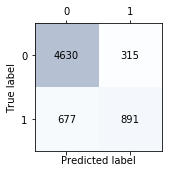

In [22]:
y_pred = RF.predict(X_test_ohe)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_train_pred = RF.predict(X_train_ohe)

print('For the test data:')
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred)) # `tp / (tp + fp)  -> 1 is the best score 
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred)) # tp / (tp + fn) -> 1 is the best score
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred)) #F1 = 2 * (precision * recall) / (precision + recall) -> f1_score

print('For the train data:')
print('Precision: %.3f' % precision_score(y_true=y_train, y_pred=y_train_pred)) # `tp / (tp + fp)  -> 1 is the best score 
print('Recall: %.3f' % recall_score(y_true=y_train, y_pred=y_train_pred)) # tp / (tp + fn) -> 1 is the best score
print('F1: %.3f' % f1_score(y_true=y_train, y_pred=y_train_pred)) #F1 = 2 * (precision * recall) / (precision + recall) -> f1_score



For the test data:
Precision: 0.739
Recall: 0.568
F1: 0.642
For the train data:
Precision: 0.992
Recall: 0.956
F1: 0.974


Text(0.5, 0, 'False Positive Rate')

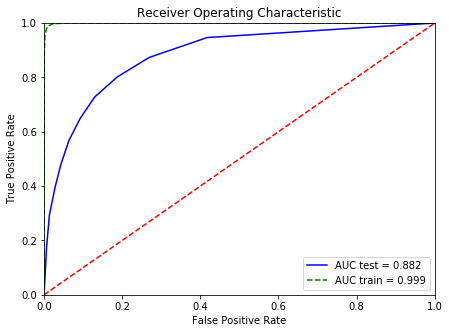

In [24]:
from sklearn.metrics import roc_curve, auc
from scipy import interp


fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []


probas_train = RF.predict_proba(X_train_ohe)
probas_test = RF.predict_proba(X_test_ohe)

fpr, tpr, threshold = roc_curve(y_test, probas_test[:,1])
roc_auc = auc(fpr, tpr)

fpr_train, tpr_train, threshold = roc_curve(y_train, probas_train[:,1])
roc_auc_train = auc(fpr_train, tpr_train)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC test = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot(fpr_train, tpr_train, 'g--', label = 'AUC train = %0.3f' % roc_auc_train)
plt.legend(loc = 'lower right')

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

Here we will use the AUC/F1 as the evaluation matrix

In [25]:
# define a function that we use to print the model performance.  
def print_score(m,X_train,y_train,X_test,y_test):
    pred_train = m.predict(X_train)
    pred_test = m.predict(X_test)
    probas_train = m.predict_proba(X_train_ohe)[:,1]
    probas_test = m.predict_proba(X_test_ohe)[:,1]
    labels = ['accuracy train','accuracy test','f1 train','f1 test','auc train','auc test']
    res = [m.score(X_train, y_train), m.score(X_test, y_test), f1_score(y_train,pred_train), f1_score(y_test,pred_test),
                metrics.roc_auc_score(y_train,probas_train), metrics.roc_auc_score(y_test,probas_test)]
    if hasattr(m, 'oob_score_'):
        res.append(m.oob_score_)
        labels.append('oob accuracy')

    for score,label in zip(res,labels):
        print(label," {0:.6f}".format(round(score,5)))
#     print(res)
    

In [26]:
print_score(RF,X_train_ohe,y_train,X_test_ohe,y_test)

accuracy train  0.987640
accuracy test  0.847690
f1 train  0.973860
f1 test  0.642390
auc train  0.999420
auc test  0.882220


# Regularization

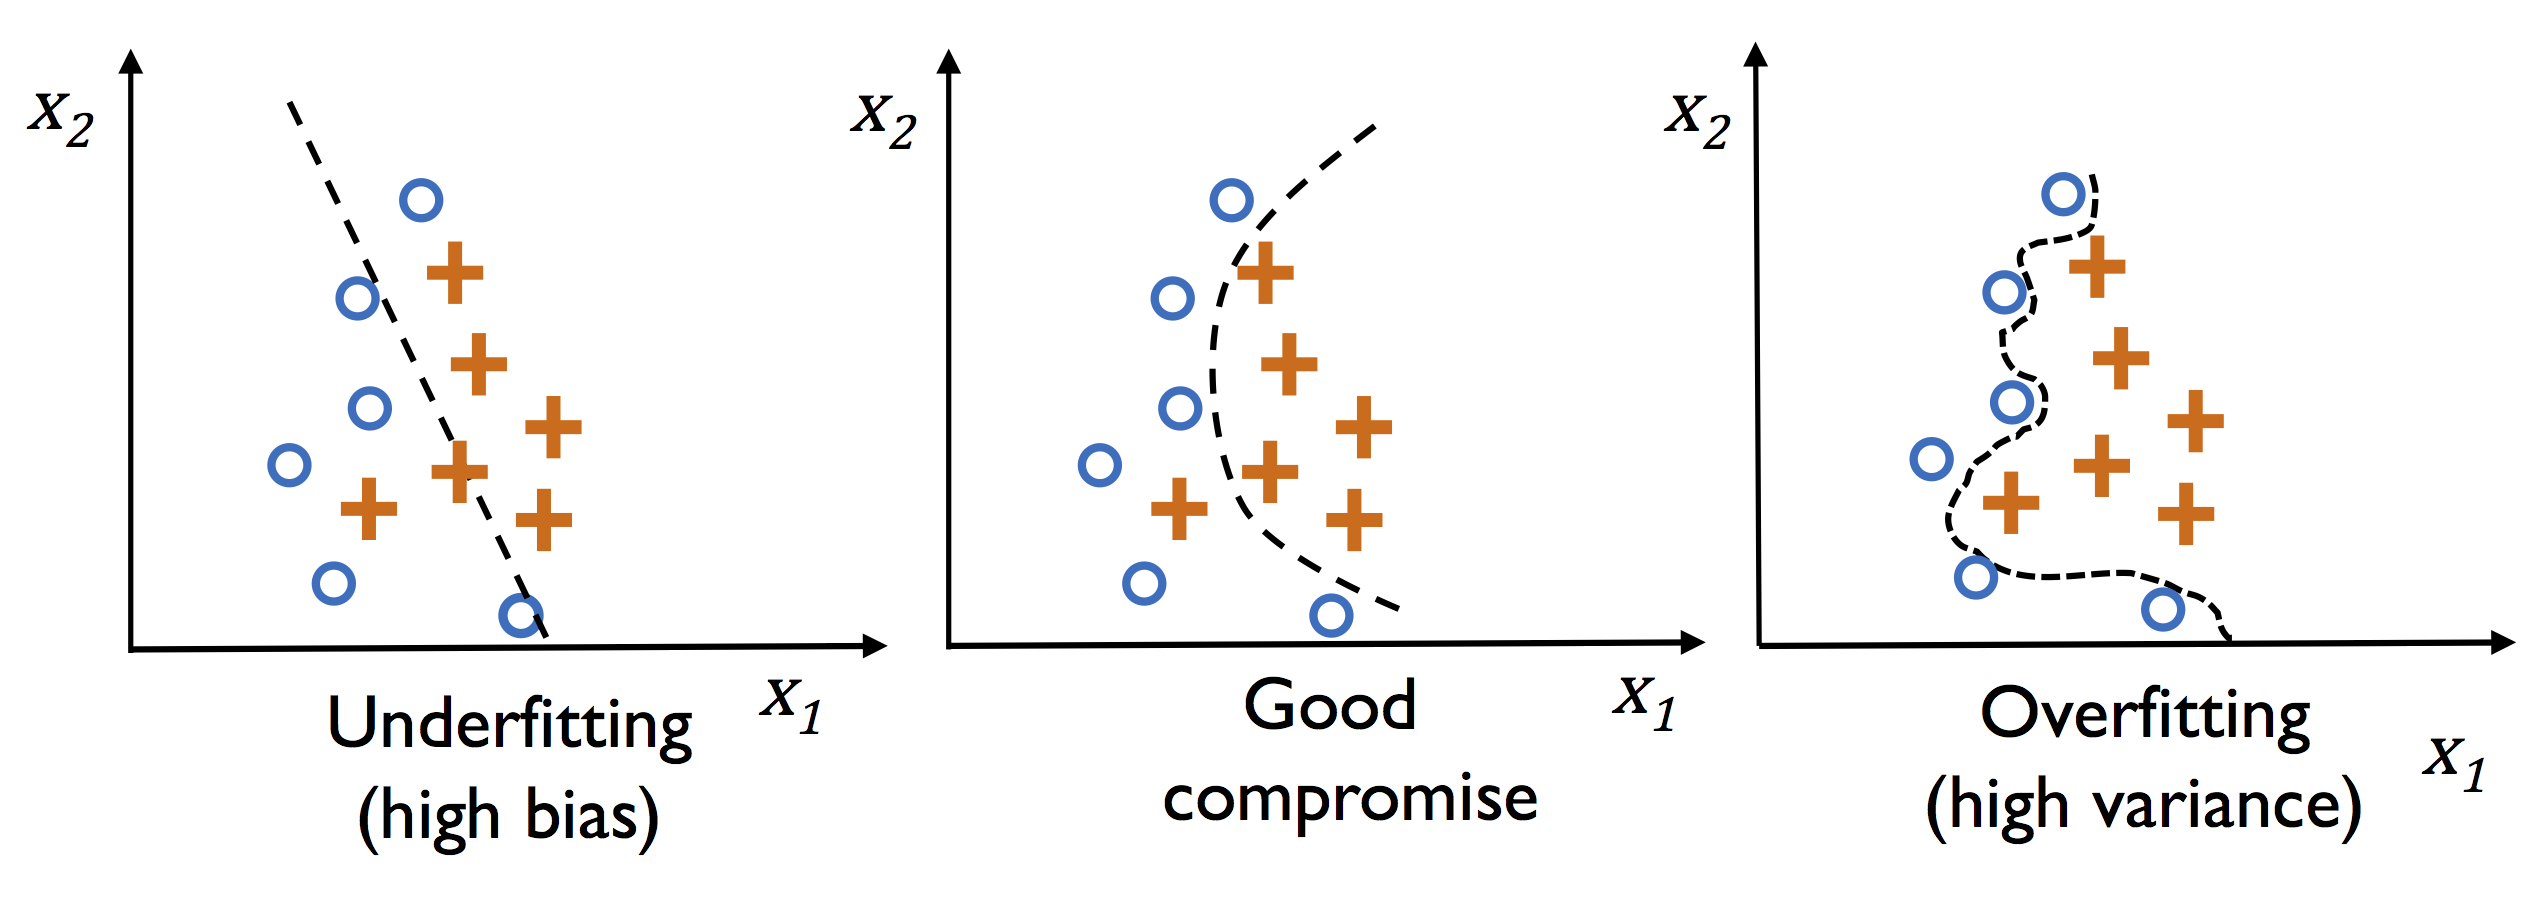

In [27]:
Image(filename='figs/overfitting.png', width=700)
# The figure below is taken from Python Machine Learning book by Sebastian Raschka


Regularization methods are aimed to tackle overfitting (cases where we succeed predicting well on a training set but failing to predict well on a test set). 

For example, the model on the far right of the plot predicts perfectly on the given set, yet it's not the best choice. Why is that? If you were to gather some new data points, they most likely would not be on that curve in the graph on the right, but would be closer to the curve in the middle graph.



All ML algorithms has some form of regularization. 

##### Useful ways to think of regularization:
- Adding a term to the loss function so that: Loss = TrainingLoss + Regularization, where regularization (a penalty that we pay for making the model more complex). 
- Putting constraints on the model to reduce its complexity/ aiming to have a better generalizability (avoid modeling the noise or ''remember'' training data)

Very braodly speaking (just to gain intuition) - if we want to reduce the training loss (reduce bias) we should try using a more complex model (if we have enough data) and if we want to reduce overfitting (reduce variace) we should simplify or constraint the model we use (increasing regularization). 


## Understanding overfitting in RandomForest

## Visualize a single tree

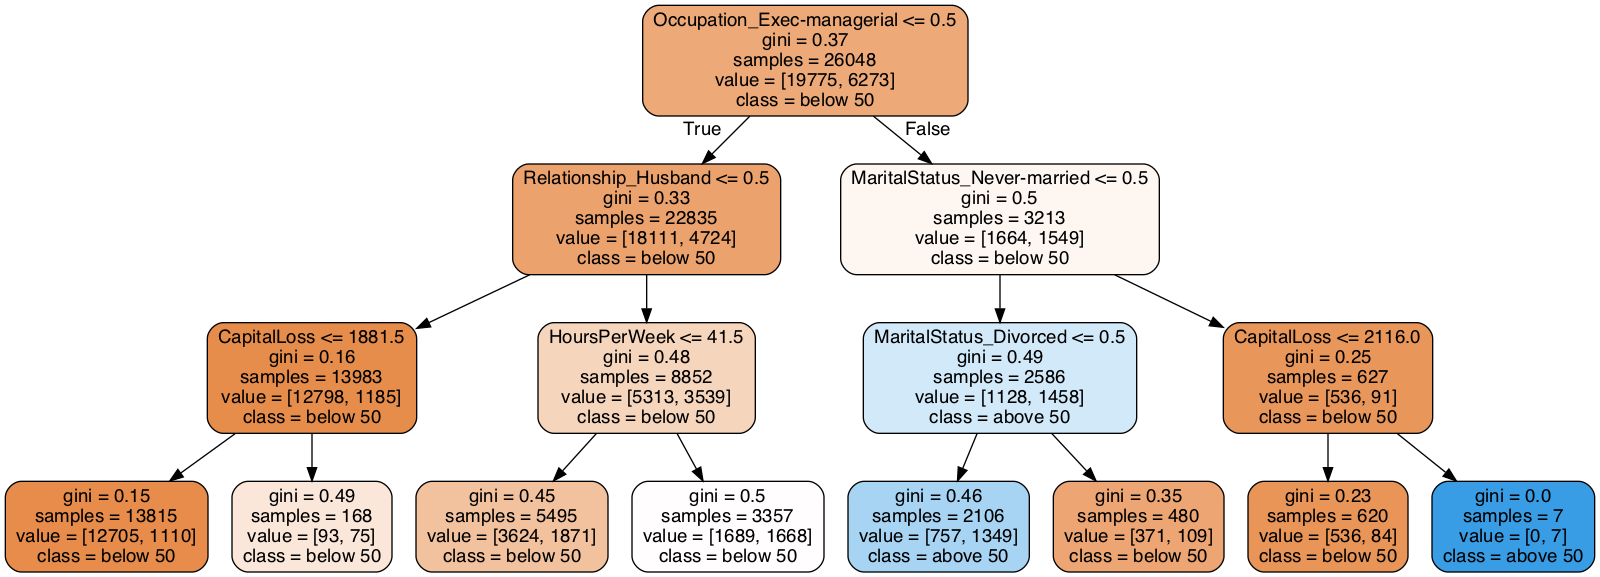

In [28]:
Image(filename='figs/tree.png', width=900)
# If you want to produce the tree image yourself - run the commented cell bellow

In [29]:
# #You might not be able to run the following code (not necessary for class) 

# RF_small = RandomForestClassifier(n_estimators=1,max_depth=3,random_state=10,bootstrap=False)
# RF_small.fit(X_train_ohe,y_train)
# # RF_small.fit(cancer_data.data,cancer_data.target)
# estimatorRF = RF_small.estimators_[0]
# from sklearn.tree import export_graphviz
# # Export as dot file
# export_graphviz(estimatorRF, out_file='tree.dot', 
#                 feature_names =  np.array(X_train_ohe.columns),
#                 class_names = ['below 50', 'above 50'],
#                 rounded = True, proportion = False, 
#                 precision = 2, filled = True)
# # from subprocess import call
# # call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])
# from subprocess import check_call
# check_call(['dot','-Tpng','tree.dot','-o','tree.png'])

# from IPython.display import Image
# Image(filename = 'tree.png')



### Impurity index for trees

Gini - is the evaluation matrix ("impurity index" which equivalent to the loss function that we try to minimize at each leaf) for how impure is each leaf (other evaluation matrices exist - see below the entropy and misclassification error) 

Text(0, 0.5, 'gini')

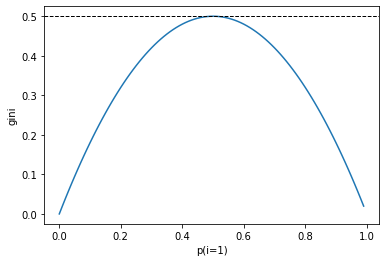

In [30]:

def gini(p):
    return p * (1 - p) + (1 - p) * (1 - (1 - p))

x = np.arange(0.0, 1.0, 0.01)

fig = plt.figure()
ax = plt.subplot(111)
    
line = ax.plot(x,gini(x))

ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
plt.xlabel('p(i=1)')
plt.ylabel('gini')




### Basic algorithm for random forest

-- Classification And Regression Tree (CART)
- Greedy algorithm (search for optimal split)  - Risk of overfitting (low bias, high variance trade-off )

The basic algorithm:
- Start with all training data the root node
- Use information gain (e.g., Gini, enthropy for classification) / MSE (the most common for regression problems) to choose which feature to split the data with (at each node). 
- Stop growing the tree when the leaf is pure (values of all samples are the same), or alternatively when got to some pruning cretrion


In [31]:
Tree_shallow = RandomForestClassifier(n_estimators=1,max_depth=3,random_state=10)
Tree_shallow.fit(X_train_ohe,y_train)
print_score(Tree_shallow,X_train_ohe,y_train,X_test_ohe,y_test) # For the RF which is not deep, we are not overfitting!

accuracy train  0.782170
accuracy test  0.785510
f1 train  0.323400
f1 test  0.343210
auc train  0.776930
auc test  0.788320


In a shallow tree there is less risk of overfitting (but also might not be able to use all the information in the data) 

In [32]:
Tree_deep = RandomForestClassifier(n_estimators=1,max_depth=50,random_state=10)
Tree_deep.fit(X_train_ohe,y_train)
print_score(Tree_deep,X_train_ohe,y_train,X_test_ohe,y_test) # For the RF which is not deep, we are not overfitting!

accuracy train  0.925450
accuracy test  0.800860
f1 train  0.843510
f1 test  0.582820
auc train  0.899920
auc test  0.726240


The shallow tree does not overfit, and can even perform better than the deep tree (see AUC of test set). 

### Bagging

-- Random Forest (see also [here](https://www.kdnuggets.com/2017/10/random-forests-explained.html)) - use an ensamble method called bagging to reduce overfitting - combine many "weak" learners to create a strong algorithm 
- Average out the outcome of individual trees, thus lowering the overfitting

- Where randomization comes from:
 - Every tree gets a different data set (usually bootstraping) - most people refer to it as bootstrap aggregation (Bagging).
 - There is a random selection of split variables.  Instead of searching greedily for the best predictors to create branches, it randomly samples elements of the predictor space. This process is also known as “feature bagging”.
 
RFs have a general tendency to overfit (so we commonly need to use regularization somehow). 
 



In [33]:
RF_deep = RandomForestClassifier(n_estimators=50,max_depth=50,random_state=10)
RF_deep.fit(X_train_ohe,y_train)
print_score(RF_deep,X_train_ohe,y_train,X_test_ohe,y_test) # For the RF which is not deep, we are not overfitting!

accuracy train  0.999310
accuracy test  0.854750
f1 train  0.998560
f1 test  0.668300
auc train  1.000000
auc test  0.903170


In this case bagging definately improved our performence on the test set, but it is still overfitting badly

In [34]:
preds = np.stack([t.predict(X_test_ohe) for t in RF_deep.estimators_])
preds[:,0], np.mean(preds[:,0]), y_test[0]

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.]),
 0.12,
 0)

In [35]:
preds.shape


(50, 6513)

<function matplotlib.pyplot.show(*args, **kw)>

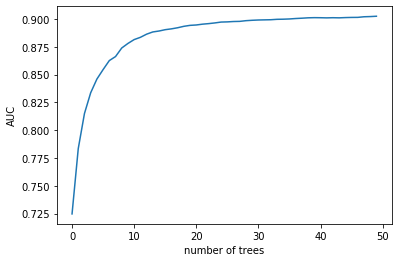

In [36]:
auc_tree_num = list()
for i in range(50):
    auc_tree_num.append(metrics.roc_auc_score(y_test, np.mean(preds[:i+1], axis=0)))
# plt.plot(metrics.roc_auc_score(y_test, np.mean(preds[:i+1], axis=0)) for i in range(10));
plt.plot(auc_tree_num)
plt.xlabel('number of trees')
plt.ylabel('AUC')
plt.show

It seems that it does not significantly helps to increase further the number of trees. 

#### Out-of-bag (OOB) score

A better score on the training set compared to the test set could be a result of qualitative differences between the test and train set (in our case this is not the case probably, but many times this might be the case).

In order to test whether we are overfiting or is it that the test set is really different from the training set -  random forests have a very clever trick called out-of-bag (OOB) error which can handle this (and more!)

The idea is to calculate error on the training set, but only include the trees in the calculation of a row's error where that row was not included in training that tree. This allows us to see whether the model is over-fitting, without needing a separate validation set.

This also has the benefit of allowing us to see whether our model generalizes, even if we only have a small amount of data so want to avoid separating some out to create a validation set.

In [37]:
RF_deep_oob = RandomForestClassifier(n_estimators=50,max_depth=50,random_state=10,oob_score=True)
RF_deep_oob.fit(X_train_ohe,y_train)
print_score(RF_deep_oob,X_train_ohe,y_train,X_test_ohe,y_test)


accuracy train  0.999310
accuracy test  0.854750
f1 train  0.998560
f1 test  0.668300
auc train  1.000000
auc test  0.903170
oob accuracy  0.852890


The fact that oob score is similar to the accuracy test means that we are overfitting and that it is not an issue that the test set is different. 

### "Regularization" in Random Forest

- Depth of the tree - reducing the depth (pruning). Can be by hard constaint to the tree depth or by some creterion determining when to stop growing a tree (e.g., max_depth, min_samples_split, min_impurity_decrease in RandomForestClassifier)
- Reduce the number of features to consider when looking for the best split (max_features in RandomForestClassifier)
#- Penalizing for growing deeper tree (ccp_alpha in RandomForestRegressor)
- subsampling 

The main hyperparameters we should tune are:
the number of trees in the forest, its maximal depth (in the plotted tree it is 4), The number of features to consider when looking for the best split (max_features) and the minimum number of samples required to be at a leaf node (min_samples_leaf).




In [38]:
# ?RandomForestClassifier

In [39]:
RF_deep_feat = RandomForestClassifier(n_estimators=50,max_depth=17,random_state=10,max_features =0.2,min_samples_leaf =5)
RF_deep_feat.fit(X_train_ohe,y_train)
print_score(RF_deep_feat,X_train_ohe,y_train,X_test_ohe,y_test) 

accuracy train  0.884250
accuracy test  0.859670
f1 train  0.728700
f1 test  0.669320
auc train  0.946580
auc test  0.917440


### Subsampling

Subsampling can be used both for training faster on our dataset (when experimenting differnet model parameters) and regularization.

The basic idea is that we can give each tree only a subset of the data. Given that we train enough trees, we will still use all availble data overall

In [40]:
#This code was written in fastai library:
from sklearn.ensemble import forest

def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

In [41]:
set_rf_samples(4000)

In [42]:
RF_subsample = RandomForestClassifier(n_estimators=130,n_jobs=-1)
%time RF_subsample.fit(X_train_ohe, y_train)
print_score(RF_subsample,X_train_ohe,y_train,X_test_ohe,y_test)

CPU times: user 1.4 s, sys: 122 ms, total: 1.53 s
Wall time: 363 ms
accuracy train  0.901410
accuracy test  0.858900
f1 train  0.775600
f1 test  0.674460
auc train  0.962540
auc test  0.913560


<function matplotlib.pyplot.show(*args, **kw)>

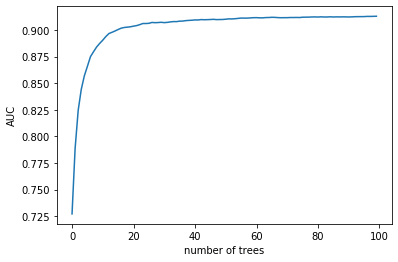

In [43]:
preds_sub = np.stack([t.predict(X_test_ohe) for t in RF_subsample.estimators_])

auc_tree_num = list()
for i in range(100):
    auc_tree_num.append(metrics.roc_auc_score(y_test, np.mean(preds_sub[:i+1], axis=0)))
# plt.plot(metrics.roc_auc_score(y_test, np.mean(preds[:i+1], axis=0)) for i in range(10));
plt.plot(auc_tree_num)
plt.xlabel('number of trees')
plt.ylabel('AUC')
plt.show

In [44]:
reset_rf_samples()

# Some visualization with dimensionality reduction (PCA)

In [45]:
# This is a function that plots the decition plots for classification (with two features)

#This pach of code is taken from Sebastian Rascha. 
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

## RF prediction visualization

In [46]:
RF_PCA = RandomForestClassifier(random_state=10)
sc = StandardScaler() # It is a good habit in general (we will see later why it is necessary. In tree based methods it is not necessary)
sc.fit(X_train_ohe) 
X_train_ohe_std = sc.transform(X_train_ohe)
X_test_ohe_std = sc.transform(X_test_ohe)


PCA_data = PCA(n_components=2)
PCA_data.fit(X_train_ohe_std)
X_train_ohe_pca = PCA_data.transform(X_train_ohe_std)
X_test_ohe_pca = PCA_data.transform(X_test_ohe_std)
RF_PCA.fit(X_train_ohe_pca,y_train);

/Users/yani/anaconda3/envs/ML_IAP/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Standardization - rescaling features  so that they’ll have a standard normal distribution with

μ=0 and σ=1

where μ is the mean (average) and σ is the standard deviation from the mean; 

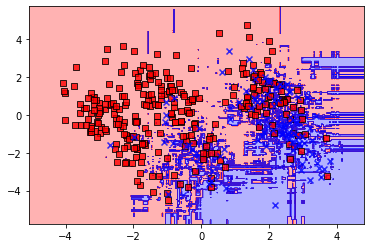

In [47]:
plot_decision_regions(X = X_train_ohe_pca[1:400,:], y=y_train[1:400], classifier=RF_PCA)

Easy to see that RF can create a complicated prediction structure.

In [48]:
# print('The logistic regession performance',LR_PCA.score(X_test_std_pca,y_test))
print('The random forest performance',RF_PCA.score(X_test_ohe_pca,y_test))

The random forest performance 0.7974819591586059


# Hyperparameter tunning and k-fold Cross Validation (CV)

Every Machine Learning model has some parameters that we can tune.
For example: 
- loss function
- Regularization form
- structure of model (e.g., in neural networks the number layers and many other parameters that we will discuss later in the course)
- Learning rate for gradient decent (discussed later in the course)

Usually, it is difficult to know the hyperparameter values that will give the 'best' performance. Therefore, we need to experimentally search for such combination of parameters. If we try many (say 100) hyperparameter combination that will be all tested on the test data set, there is a risk that we will get a very good performance on the test set  by chance  (especially if it is a small dataset!). 
Therefore, when we are tuning hyperparameters, we divide again the training data - to a new training dataset (smaller than the previous one) and a CV dataset (which is a new test set). 

Comment: Creating a reliable CV might be a very challenging task in certain datasets (think in which situations choosing samples at random will not be a representing CV dataset)

### K-fold cross-validation


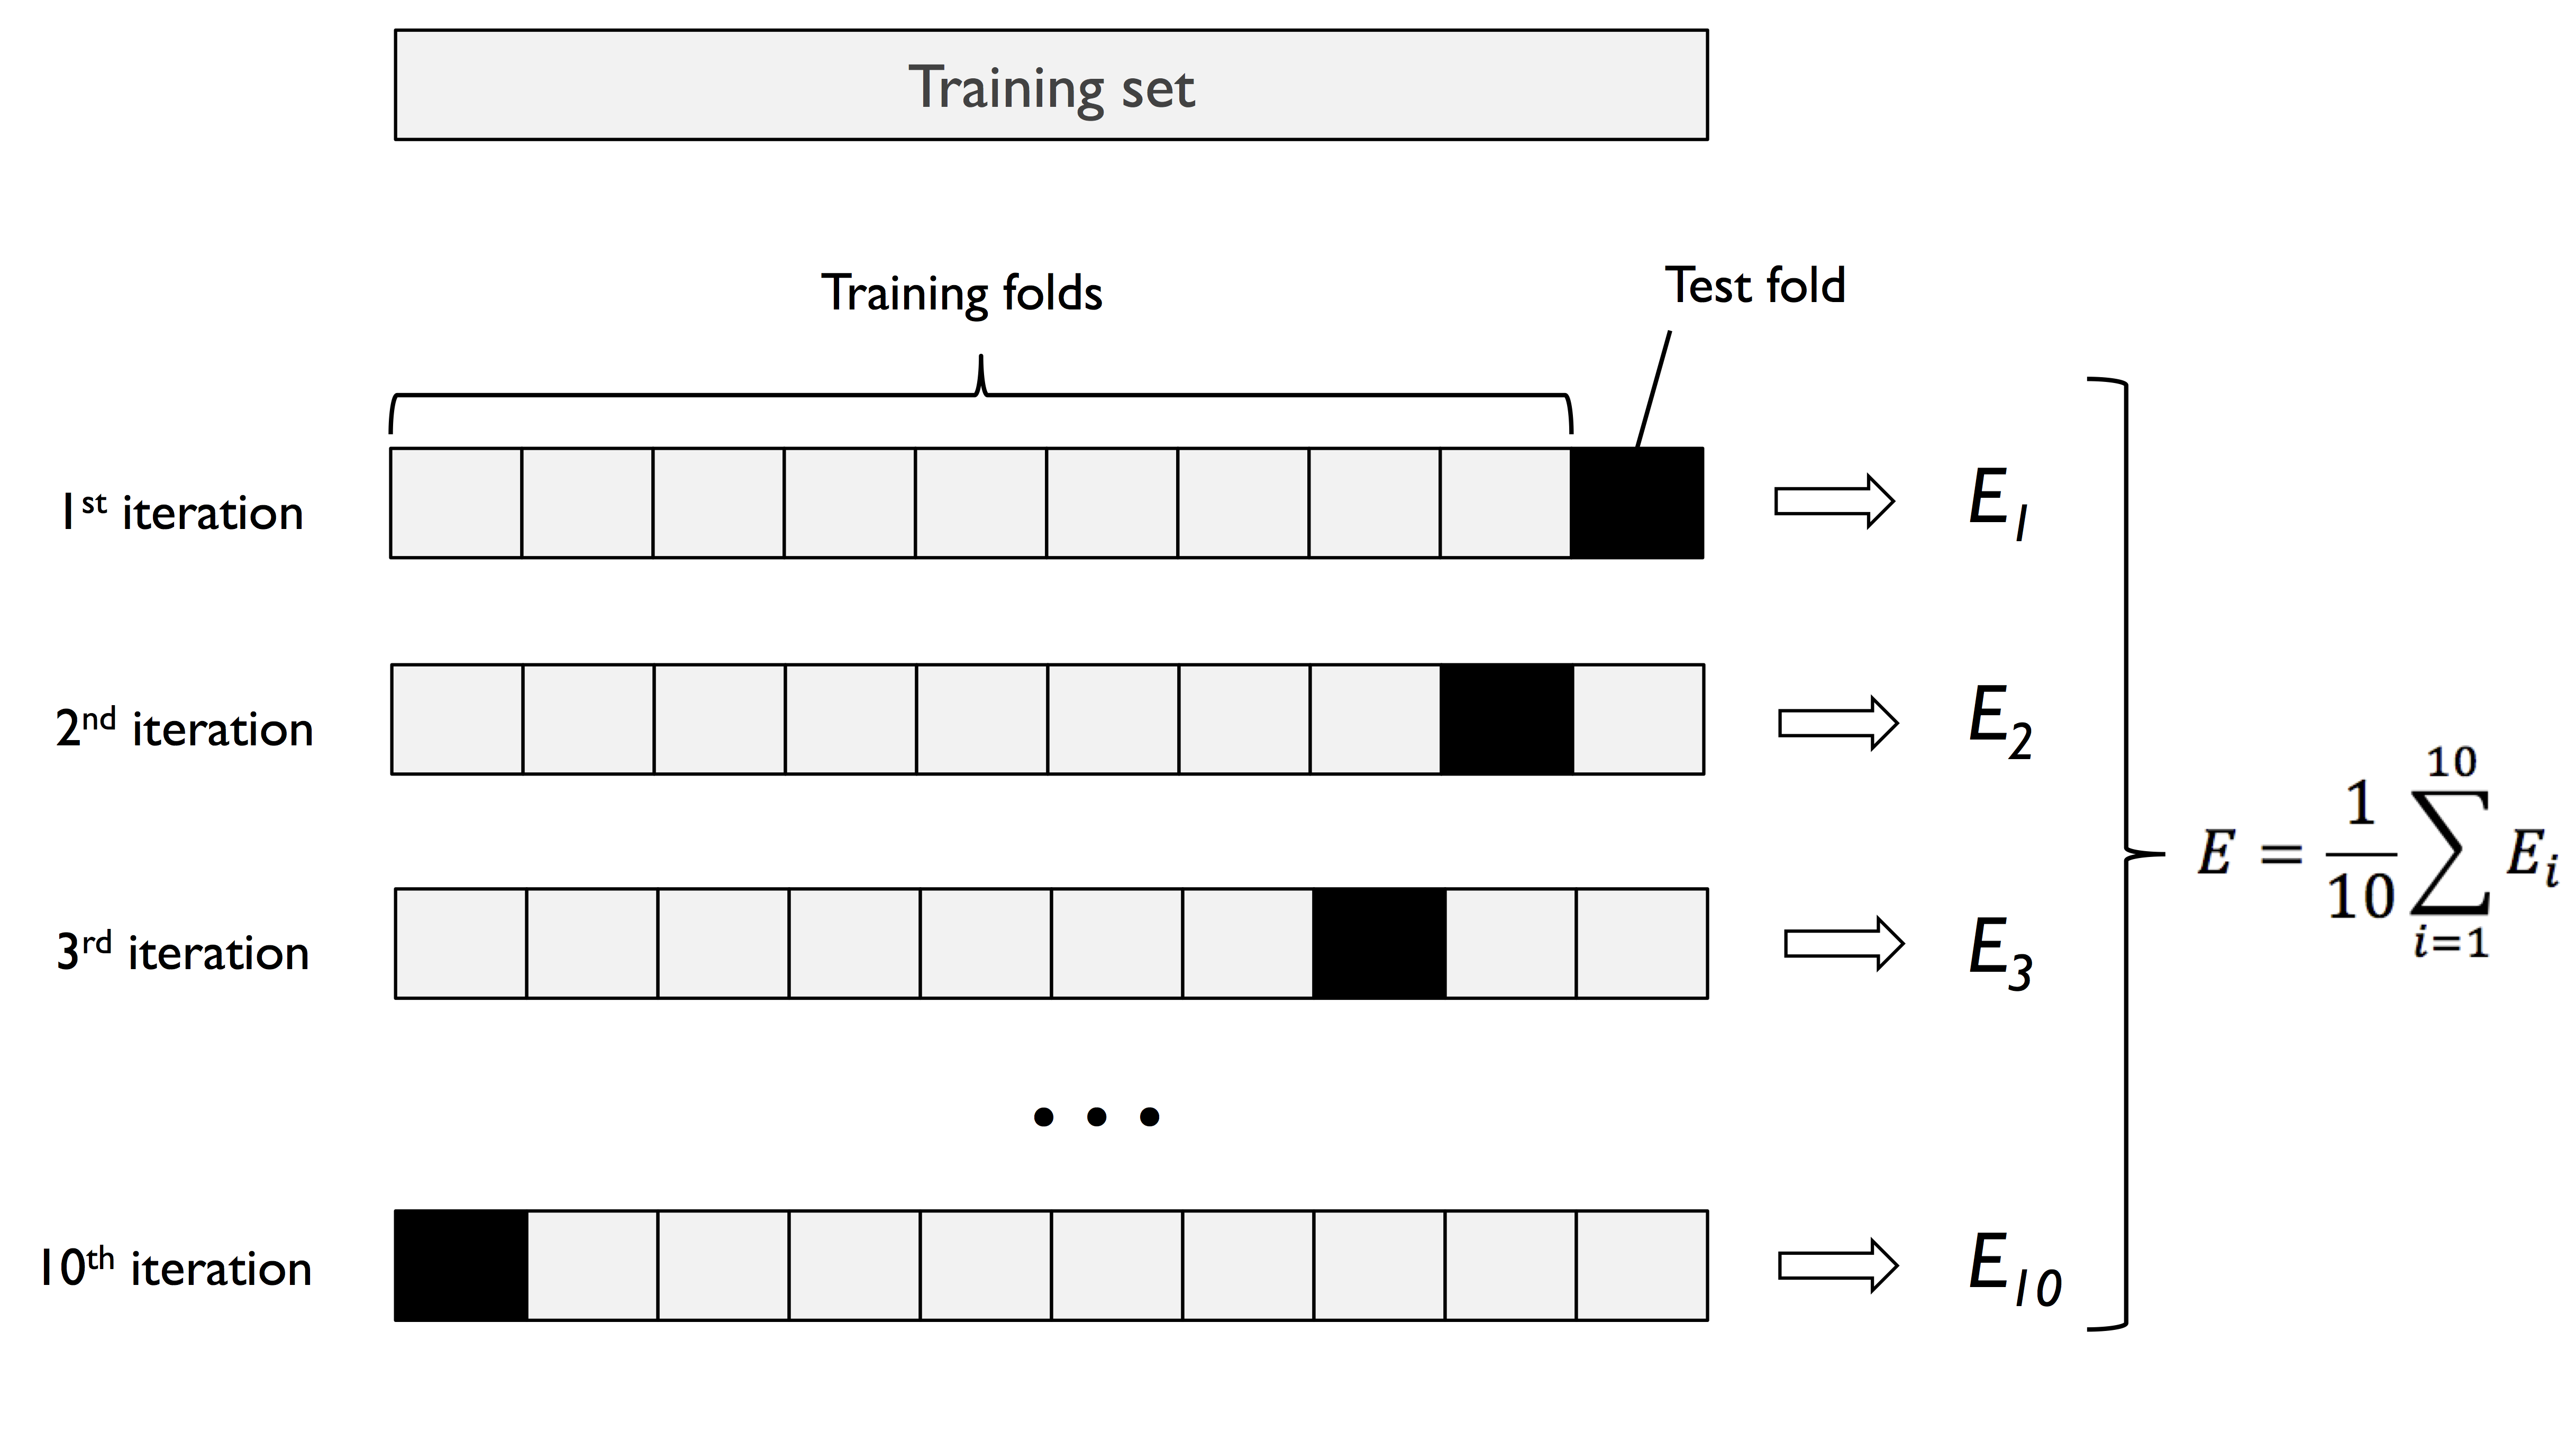

In [49]:
# Image from Sebastian's Raschka book
Image(filename='figs/k_cross_validation.png', width=700)


### Pipelines

Pipelines allow us to fit a model including an arbitrary number of
transformation steps and apply it to make predictions for new data.

In [50]:
# An RF pipeline that first standardize the data and later use PCA for dimensionality reduction.
pipe_RF = make_pipeline(PCA(n_components=2),
                        RandomForestClassifier(random_state=10))

In [51]:
pipe_RF.fit(X_train_ohe,y_train);

/Users/yani/anaconda3/envs/ML_IAP/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [52]:
pipe_RF.score(X_test_ohe,y_test)

0.7595578074619991

In [53]:
# An RF pipeline that first standardize the data and later use PCA for dimensionality reduction.


### Example: tuning a random forest (need to use cross validation). 

In [54]:

pipe_RF = make_pipeline(PCA(n_components=2),RandomForestClassifier(random_state=1))

max_depth_list = [1,4] # For simplicity I am using shallow tree
max_features_list = [0.1,'auto']
Tree_num_list = [10,50]
param_grid = [{'randomforestclassifier__max_depth': max_depth_list, 
               'randomforestclassifier__n_estimators': Tree_num_list,
              'randomforestclassifier__max_features': max_features_list}]

gs = GridSearchCV(estimator=pipe_RF, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  refit=True,
                  cv=5,
                  n_jobs=-1)
gs = gs.fit(X_train_ohe, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.8032478501228502
{'randomforestclassifier__max_depth': 4, 'randomforestclassifier__max_features': 0.1, 'randomforestclassifier__n_estimators': 50}


In [55]:
#Printing results for all RFs that we fitted. 
for i in range(gs.cv_results_['std_test_score'].shape[0]):
    print('For RF with features:', gs.cv_results_['params'][i])
    print('The mean test accuracy is:', gs.cv_results_['mean_test_score'][i], '+/-', gs.cv_results_['std_test_score'][i])

    

For RF with features: {'randomforestclassifier__max_depth': 1, 'randomforestclassifier__max_features': 0.1, 'randomforestclassifier__n_estimators': 10}
The mean test accuracy is: 0.7591753685503686 +/- 7.139235192641306e-05
For RF with features: {'randomforestclassifier__max_depth': 1, 'randomforestclassifier__max_features': 0.1, 'randomforestclassifier__n_estimators': 50}
The mean test accuracy is: 0.8016738329238329 +/- 0.0018120583188597158
For RF with features: {'randomforestclassifier__max_depth': 1, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__n_estimators': 10}
The mean test accuracy is: 0.7591753685503686 +/- 7.139235192641306e-05
For RF with features: {'randomforestclassifier__max_depth': 1, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__n_estimators': 50}
The mean test accuracy is: 0.8016738329238329 +/- 0.0018120583188597158
For RF with features: {'randomforestclassifier__max_depth': 4, 'randomforestclassifier__max_featur

# Learning curve 

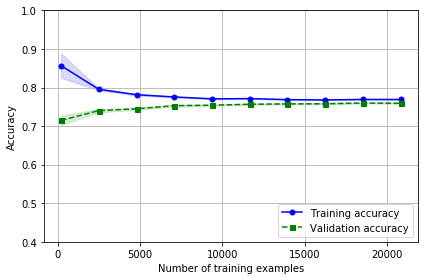

In [56]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


pipe_lr = make_pipeline(
                        RandomForestClassifier(n_estimators=10))

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X_train_ohe[X_train_ohe.columns[0:10]], #Note that I use only the first 10 features for simplicity
                               y=y_train,
                               train_sizes=np.linspace(0.01, 1.0, 10),
                               cv=5,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.4, 1.0])
plt.tight_layout()

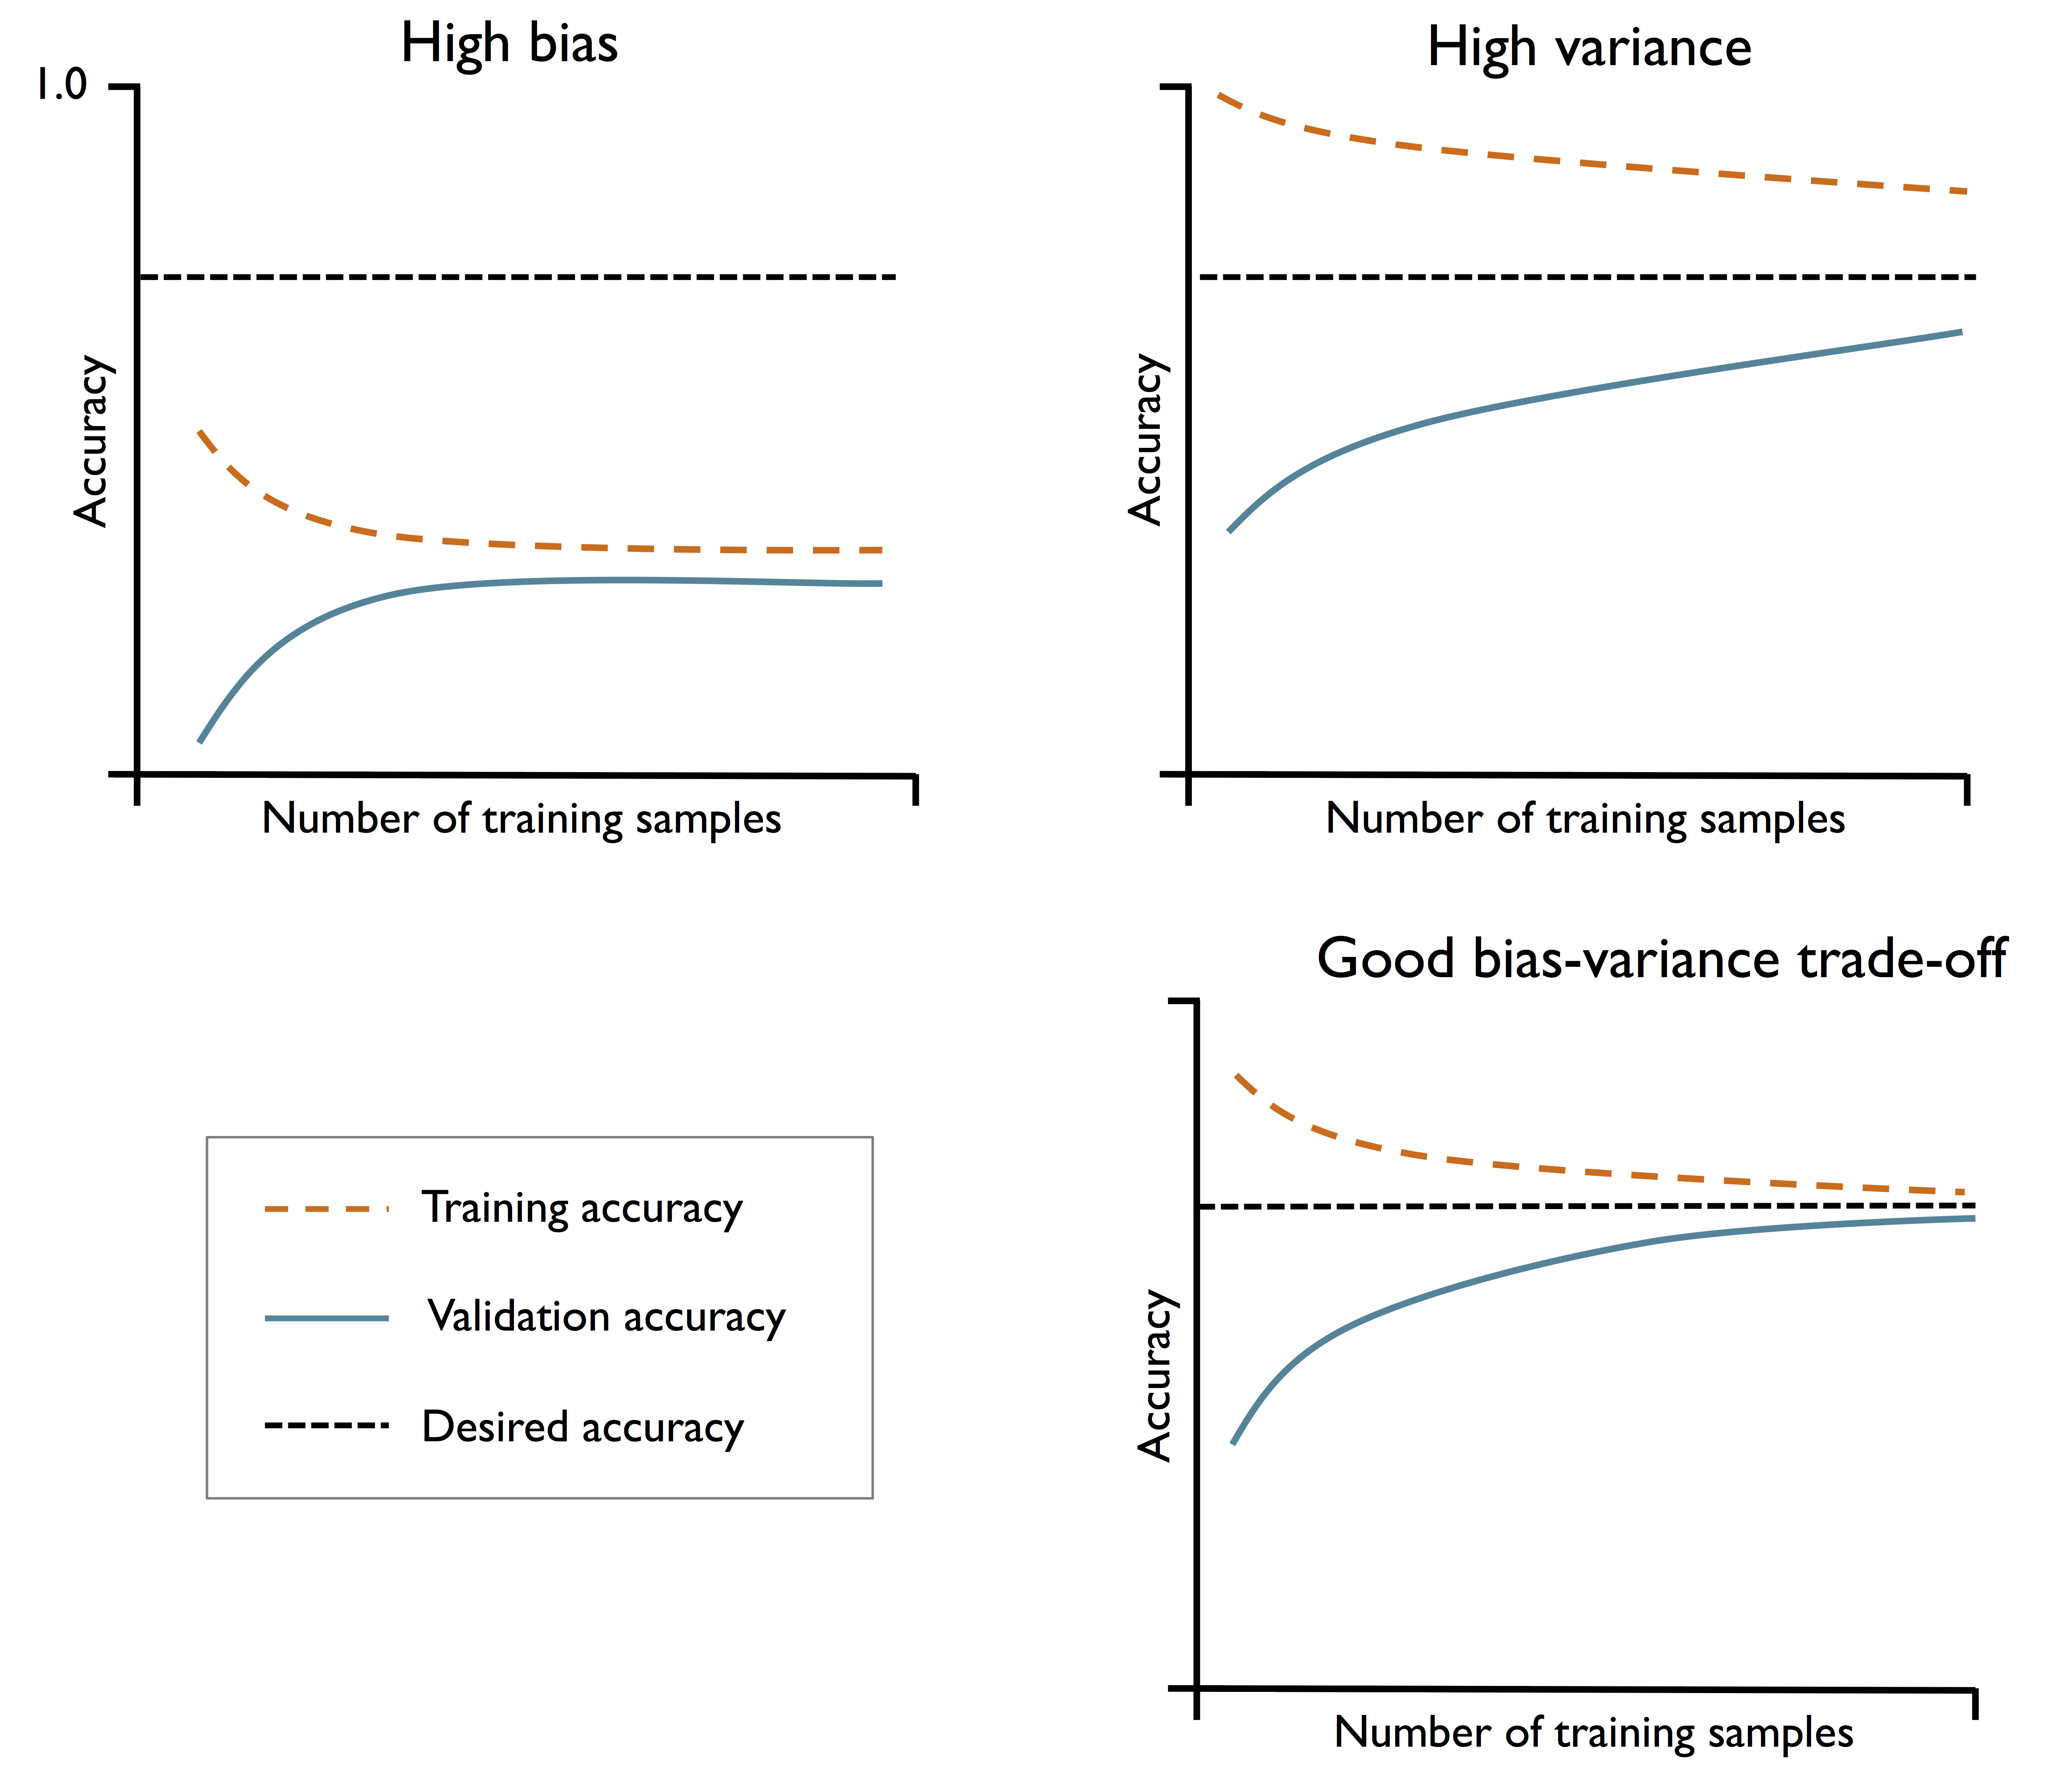

In [58]:
# Image from Sebastian's Raschka book


# Image(filename='/Users/yani/Dropbox/MIT/ML_IAP/Python_machine_learning_repo/python-machine-learning-book-3rd-edition/ch06/images/06_04.png', width=700)
Image(filename='figs/Learning_curve.png', width=700)


##  terms that you should know after the class:
- Regularization
- Loss (Cost) function
- RandomForest 
- AUC and Confusion matrix
- Learning curve
- categorical/ordinal vs continuous variables

In [ ]:
####